In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from helpers import sql

# pandas formatting
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', 200)

In [2]:
status_columns = [
    'submission_date',
    'date_chair_sent',
    'date_chair_appr',
    'date_coordinator_sent',
    'date_coordinator_appr',
    'date_section_head_sent',
    'date_section_head_appr',
    'date_division_manager_sent',
    'date_division_manager_appr',
    'date_director_sent',
    'date_director_appr',
    'date_doc_submitted',
    'date_proof_author_sent',
    'date_proof_author_approved',
    'actual_posting_date',
    # 'updated_posting_date',  # IGNORE updated_posting_date
]

translation_status_columns = [
    'date_translation_sent',
    'date_returned',
    'translation_review_date',
]

submission_steps = [
    'submission_date', 
    'date_doc_submitted', 
    'actual_posting_date'
]

all_steps = [
    'submission_date',
    'date_chair_sent',
    'date_chair_appr',
    'date_coordinator_sent',
    'date_coordinator_appr',
    'date_section_head_sent',
    'date_section_head_appr',
    'date_division_manager_sent',
    'date_division_manager_appr',
    'date_director_sent',
    'date_director_appr',
    'date_translation_sent',
    'date_returned',
    'translation_review_date',
    'date_doc_submitted',
    'date_proof_author_sent',
    'date_proof_author_approved',
    'actual_posting_date',
]

document_types = {
    2: "SAR",  # 56 days due
    3: "RES",  # 122 days due
    4: "PRO",  # 122 days due
    5: "SRR",  # 56 days due
    6: "working_paper",
    8: "translation_only",
}

In [3]:
# import tables
tracking = sql("SELECT * FROM csas2_documenttracking JOIN csas2_document ON csas2_document.id = document_id")

tracking['document_type'] = tracking['document_type_id'].map(document_types)
tracking = tracking[tracking['status'] != 99]

sar_tracking = tracking[tracking.document_type != "SAR"].copy()
res_tracking = tracking[tracking.document_type != "RES"].copy()
pro_tracking = tracking[tracking.document_type != "PRO"].copy()
srr_tracking = tracking[tracking.document_type != "SRR"].copy()

In [4]:
def time_matrix(dataframe, col_lst, all_stats=False, quantile=0.5):
    df_temp = dataframe[col_lst].apply(pd.to_datetime, errors='coerce')
    matrix = pd.DataFrame(index=col_lst, columns=col_lst)
    
    for i, from_step in enumerate(col_lst):
        for j, to_step in enumerate(col_lst):
            if i < j:
                if all_stats:
                    matrix.loc[from_step, to_step] = (
                        round((df_temp[to_step] - df_temp[from_step]).dt.days.mean(), 1),
                        round((df_temp[to_step] - df_temp[from_step]).dt.days.quantile([0.025, 0.16, 0.5, 0.84, 0.975]), 1),
                    )
                else:
                    matrix.loc[from_step, to_step] = round((df_temp[to_step] - df_temp[from_step]).dt.days.quantile(quantile), 1)
                
    return matrix.apply(pd.to_numeric, errors='coerce').dropna(how='all').dropna(how='all', axis=1)


def diagonal(dataframe, col_lst, name, quantile=0.5):
    matrix = time_matrix(dataframe, col_lst, quantile=quantile)
    diagonal_values = matrix.values.diagonal()
    labels = [f"{matrix.index[i]} > {matrix.columns[i]}" for i in range(len(diagonal_values))]
    return pd.Series(diagonal_values, index=labels, name=name)


def plot_heatmap(dataframe, col_lst, quantile=0.5, figsize=(8, 8)):
    plt.figure(figsize=figsize)
    
    matrix = time_matrix(dataframe, col_lst, quantile=quantile).fillna(-99)
    annot = matrix.map(lambda x: f"{int(x)}" if x >= 0 else "")
    
    fig = sns.heatmap(
        matrix, 
        annot=annot, 
        cmap='Blues',
        vmin=-10,
        vmax=100,
        fmt='', 
        cbar=False
    )
    
    fig.xaxis.set_ticks_position('top')
    fig.tick_params(axis='x', rotation=90, length=0)
    fig.tick_params(axis='x', rotation=90)
    
    plt.show()
    

def plot_all_heatmaps(dataframe, quantile=0.5, separated_steps=False):
    if separated_steps:
        plot_heatmap(dataframe, status_columns, quantile=quantile)
        plot_heatmap(dataframe, translation_status_columns, figsize=(1, 1), quantile=quantile)
        plot_heatmap(dataframe, submission_steps, figsize=(1, 1), quantile=quantile)
    else:
        plot_heatmap(dataframe, all_steps, quantile=quantile)

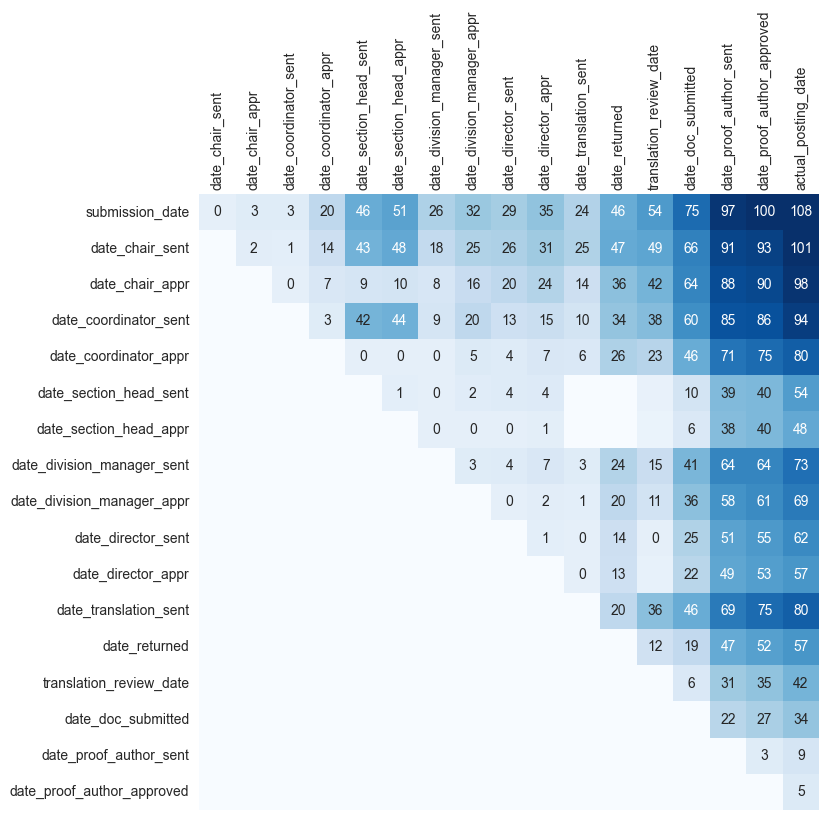

In [5]:
plot_all_heatmaps(tracking)

sar_tracking


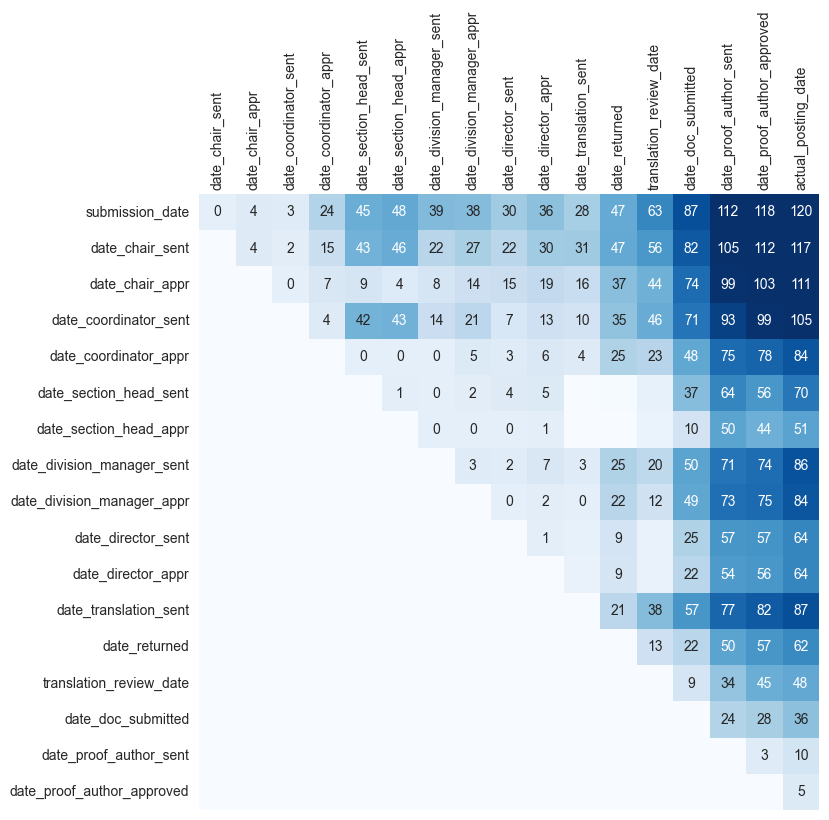

res_tracking


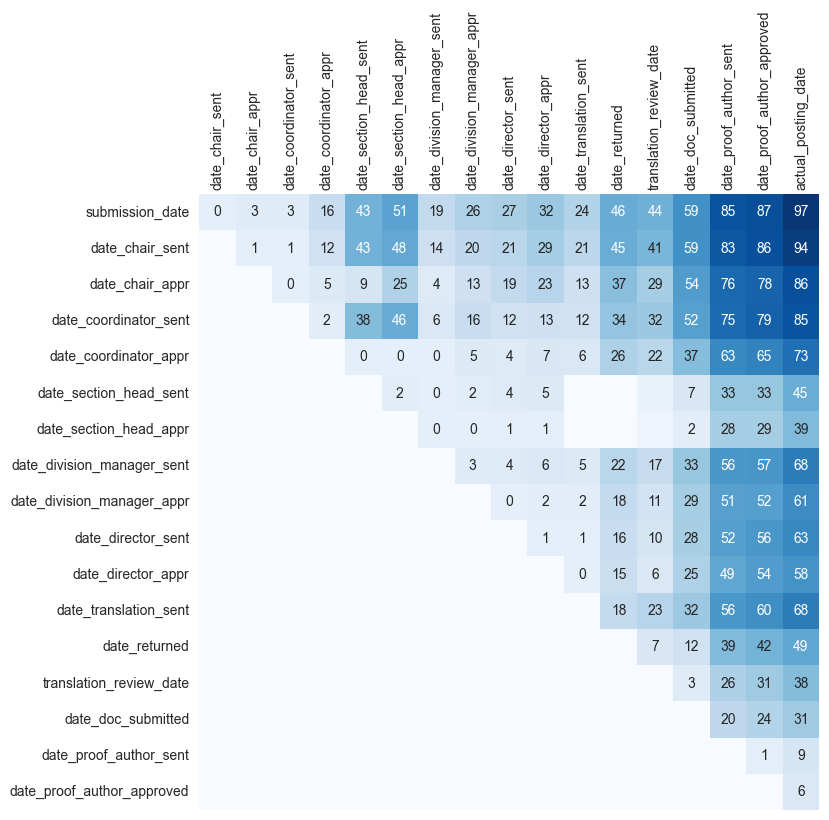

pro_tracking


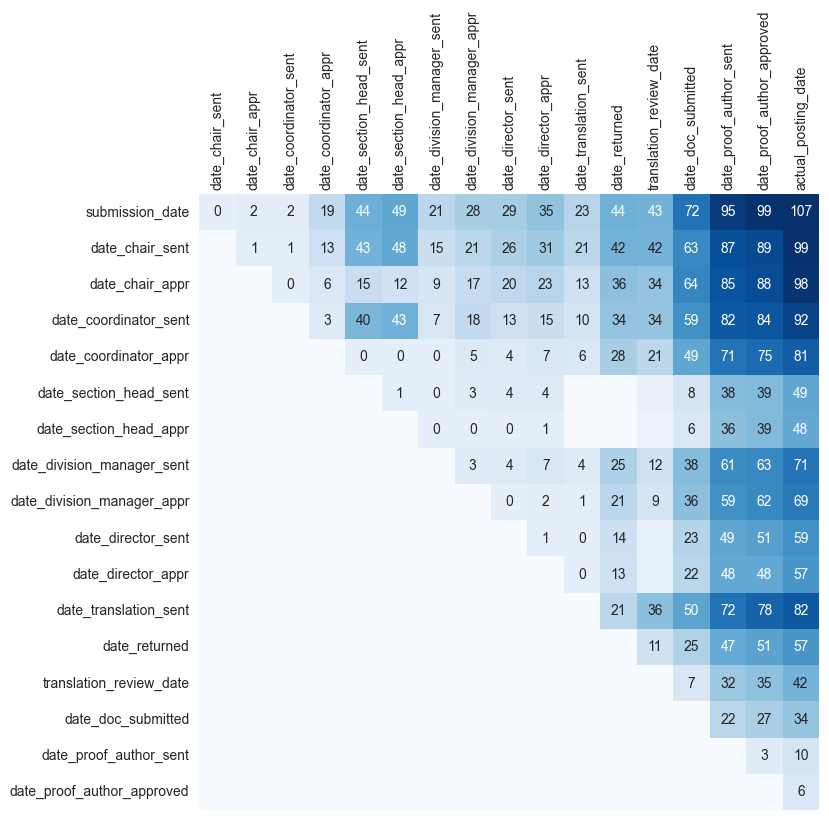

srr_tracking


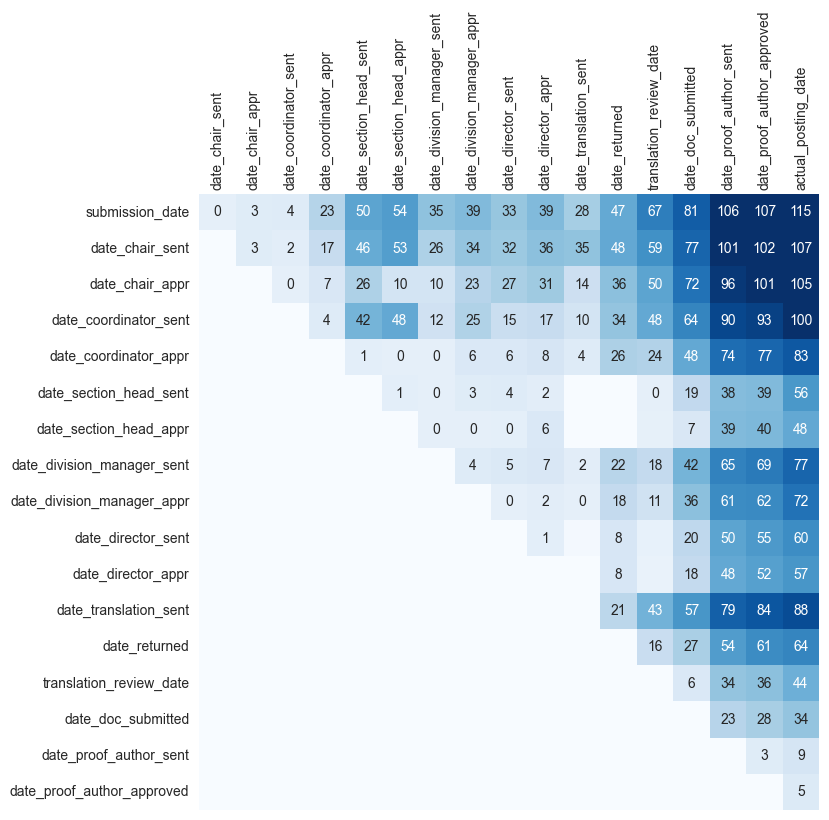

In [6]:
print('sar_tracking')
plot_all_heatmaps(sar_tracking)
print('res_tracking')
plot_all_heatmaps(res_tracking)
print('pro_tracking')
plot_all_heatmaps(pro_tracking)
print('srr_tracking')
plot_all_heatmaps(srr_tracking)

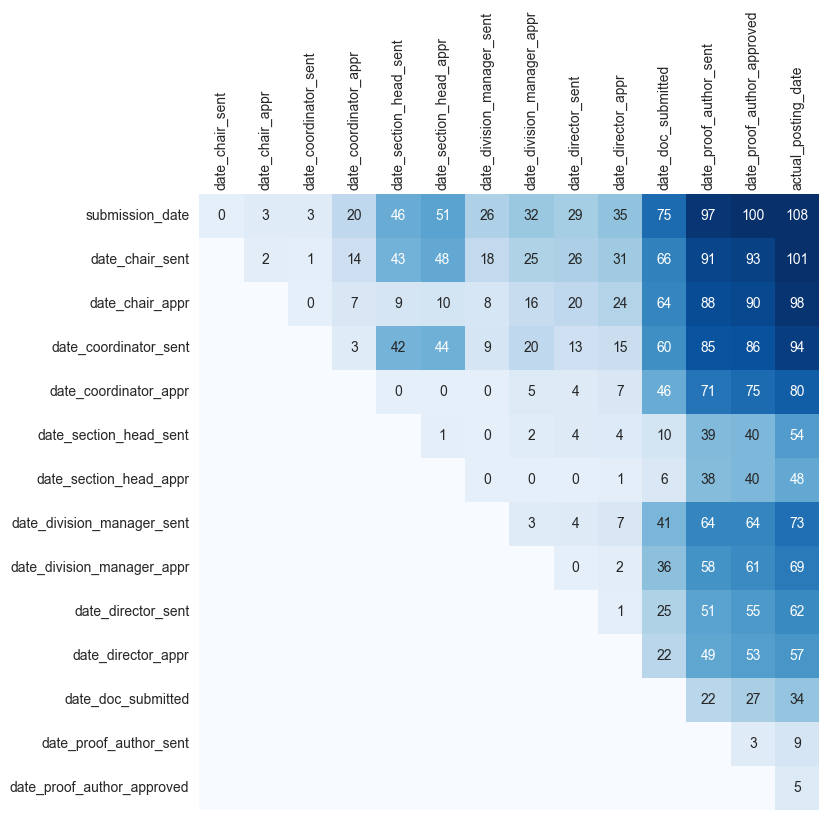

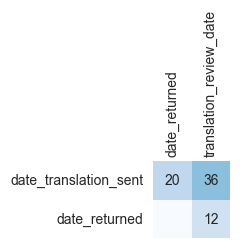

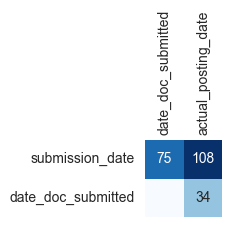

In [7]:
plot_all_heatmaps(tracking, separated_steps=True)

sar_tracking


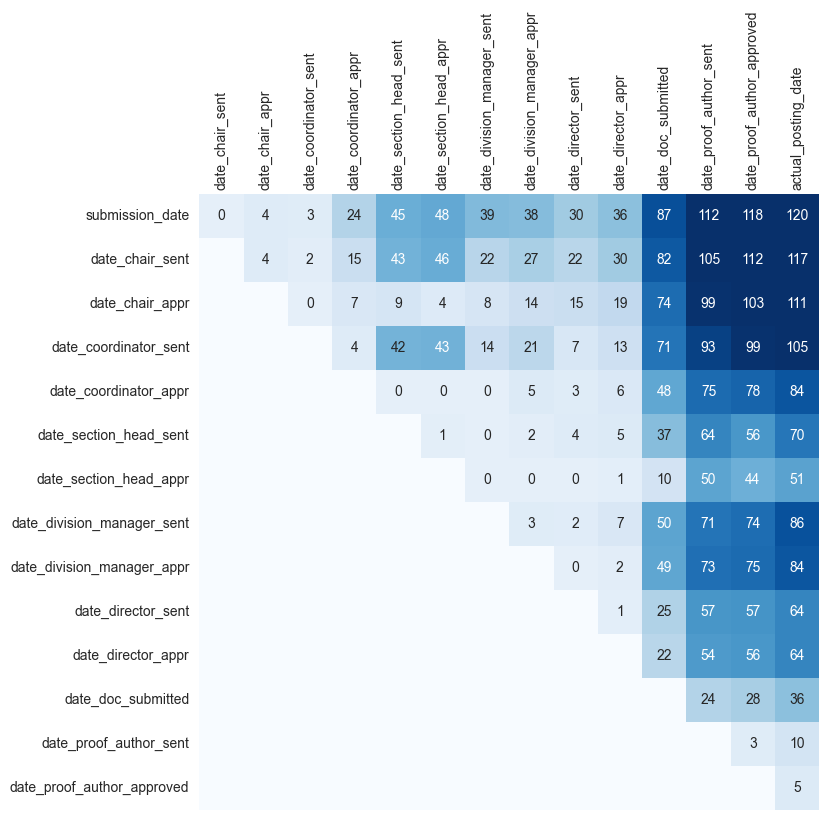

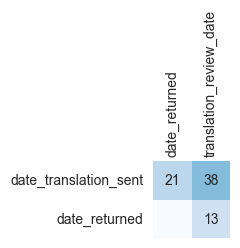

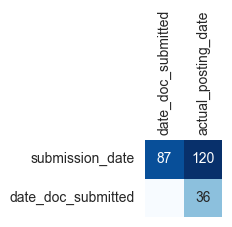

res_tracking


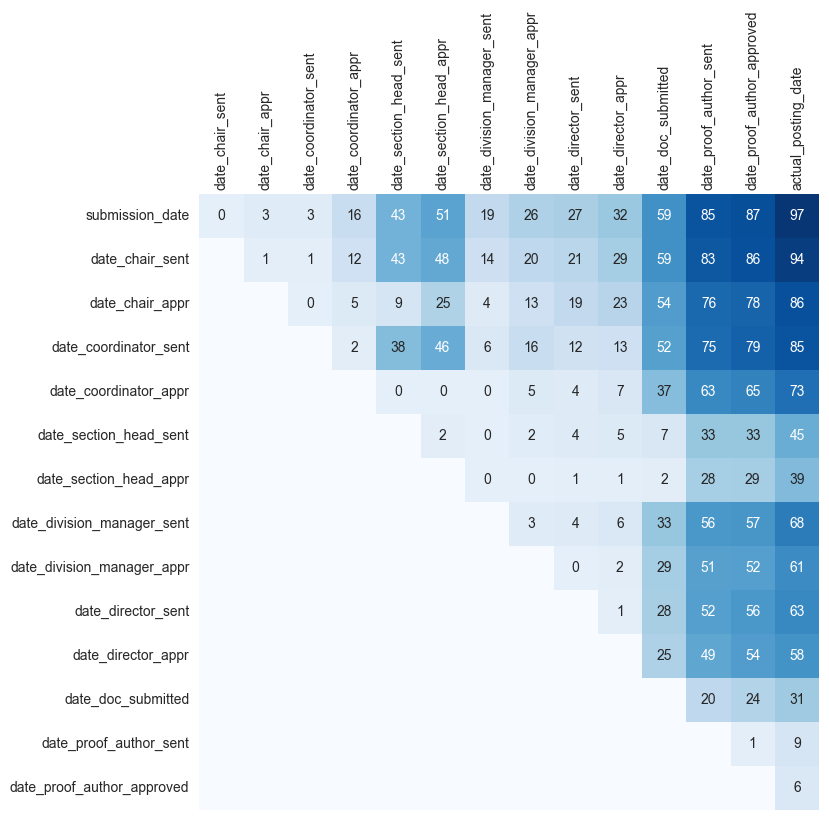

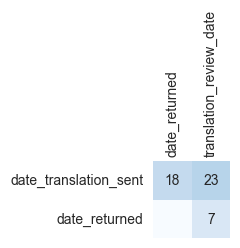

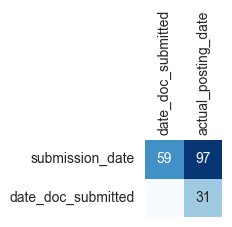

pro_tracking


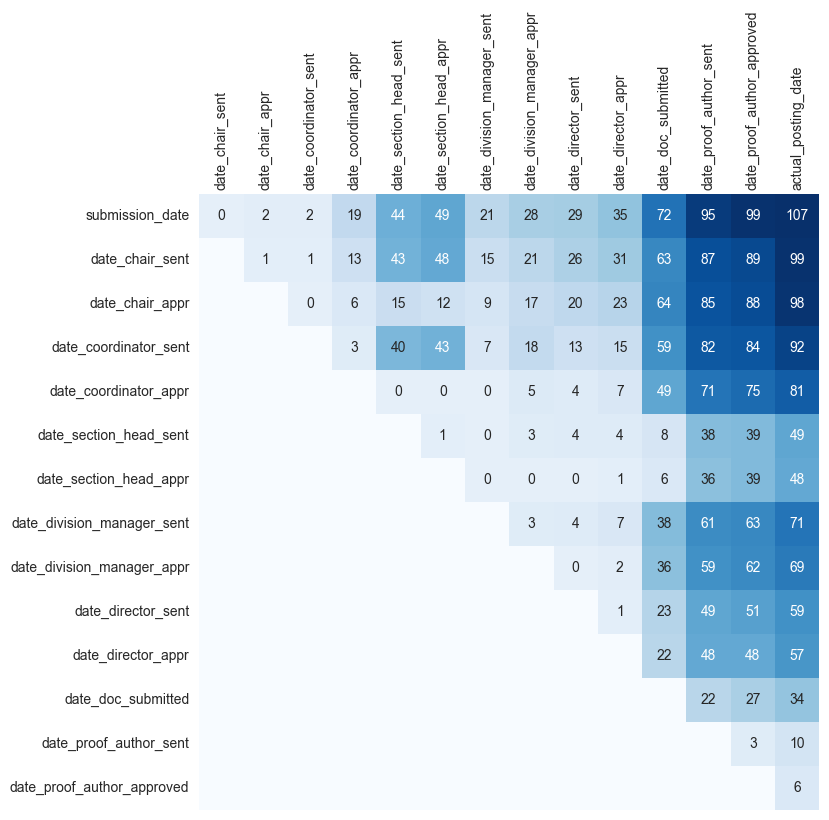

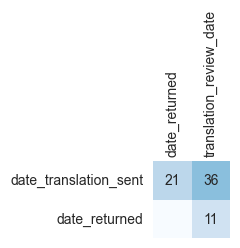

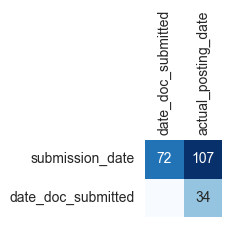

srr_tracking


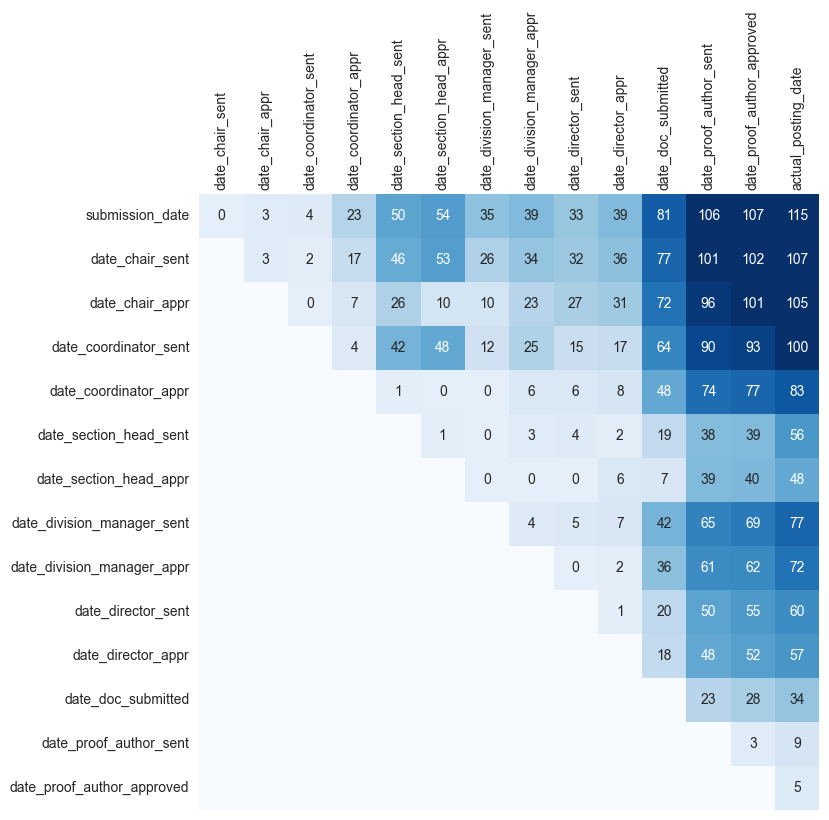

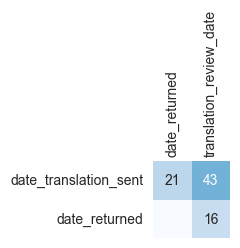

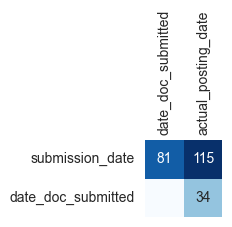

In [8]:
print('sar_tracking')
plot_all_heatmaps(sar_tracking, separated_steps=True)
print('res_tracking')
plot_all_heatmaps(res_tracking, separated_steps=True)
print('pro_tracking')
plot_all_heatmaps(pro_tracking, separated_steps=True)
print('srr_tracking')
plot_all_heatmaps(srr_tracking, separated_steps=True)